In [174]:
import pandas as pd
import numpy as np 
import matplotlib.pyplot as plt
from sklearn.ensemble import RandomForestClassifier
from sklearn.metrics import classification_report
from statsmodels.tsa.seasonal import seasonal_decompose
import seaborn as sns
from sklearn.metrics import confusion_matrix

# Read Data

In [162]:
df = pd.read_csv('data/OHLC_VN30F1M.csv')
df

,Time,Timestamp,Symbol,Open,High,Low,Close,Volume,Resolution,Last Updated
0,2018-08-13T02:00:00,1534125600,VN30F1M,943.5,943.5,942.9,942.9,975.0,MIN1,1570509583
1,2018-08-13T02:01:00,1534125660,VN30F1M,943.0,943.1,942.9,943.1,220.0,MIN1,1570509583
2,2018-08-13T02:02:00,1534125720,VN30F1M,943.0,943.6,943.0,943.5,121.0,MIN1,1570509583
3,2018-08-13T02:03:00,1534125780,VN30F1M,943.3,943.4,943.3,943.4,135.0,MIN1,1570509583
4,2018-08-13T02:04:00,1534125840,VN30F1M,943.2,943.2,943.0,943.1,361.0,MIN1,1570509583
...,...,...,...,...,...,...,...,...,...,...
359850,2025-01-21T07:27:00,1737444420,VN30F1M,1320.9,1321.5,1320.9,1321.3,2304.0,MIN1,1737444477
359851,2025-01-21T07:28:00,1737444480,VN30F1M,1321.2,1321.3,1320.6,1320.7,1166.0,MIN1,1737444536
359852,2025-01-21T07:29:00,1737444540,VN30F1M,1320.7,1321.3,1320.5,1321.3,1614.0,MIN1,1737444598
359853,2025-01-21T07:30:00,1737444600,VN30F1M,1321.3,1321.3,1321.3,1321.3,64.0,MIN1,1737444602


In [163]:
# Tạo thêm feature Close_15mins_after đại diện cho Close Price sau 15 phút
df["Close_15mins_after"] = df["Close"].shift(-15)
df['Pct_Change'] = (df['Close_15mins_after']-df['Close']) / df['Close'] * 100
df.dropna(inplace=True)
df.describe()

,Timestamp,Open,High,Low,Close,Volume,Last Updated,Close_15mins_after,Pct_Change
count,3.598400e+05,359840.000000,359840.000000,359840.000000,359840.000000,359840.000000,3.598400e+05,359840.000000,359840.000000
mean,1.631594e+09,1117.049956,1117.406294,1116.694050,1117.049881,780.620201,1.635508e+09,1117.065608,0.001998
std,5.912030e+07,240.925080,240.993732,240.854919,240.923491,1009.673876,5.645206e+07,240.924452,0.345763
min,1.534126e+09,563.000000,566.000000,560.100000,565.000000,1.000000,1.546394e+09,565.000000,-8.599537
25%,1.581388e+09,891.000000,891.100000,890.800000,891.000000,285.000000,1.581914e+09,891.000000,-0.103306
50%,1.628131e+09,1106.900000,1107.400000,1106.300000,1106.900000,538.000000,1.628131e+09,1106.900000,0.000000
75%,1.675224e+09,1306.900000,1307.200000,1306.500000,1306.900000,967.000000,1.675224e+09,1306.900000,0.111841
max,1.737444e+09,1576.600000,1576.900000,1575.800000,1576.700000,158907.000000,1.737444e+09,1576.700000,14.466358


# Train Test Split

In [164]:
num_days = 30
test_size = 60*24*num_days
features = ['Open', 'High', 'Low', 'Close', 'Volume']
X_train = df[features].iloc[:-test_size]
X_test = df[features].iloc[-test_size:]

Text(0.5, 1.0, 'Volume')

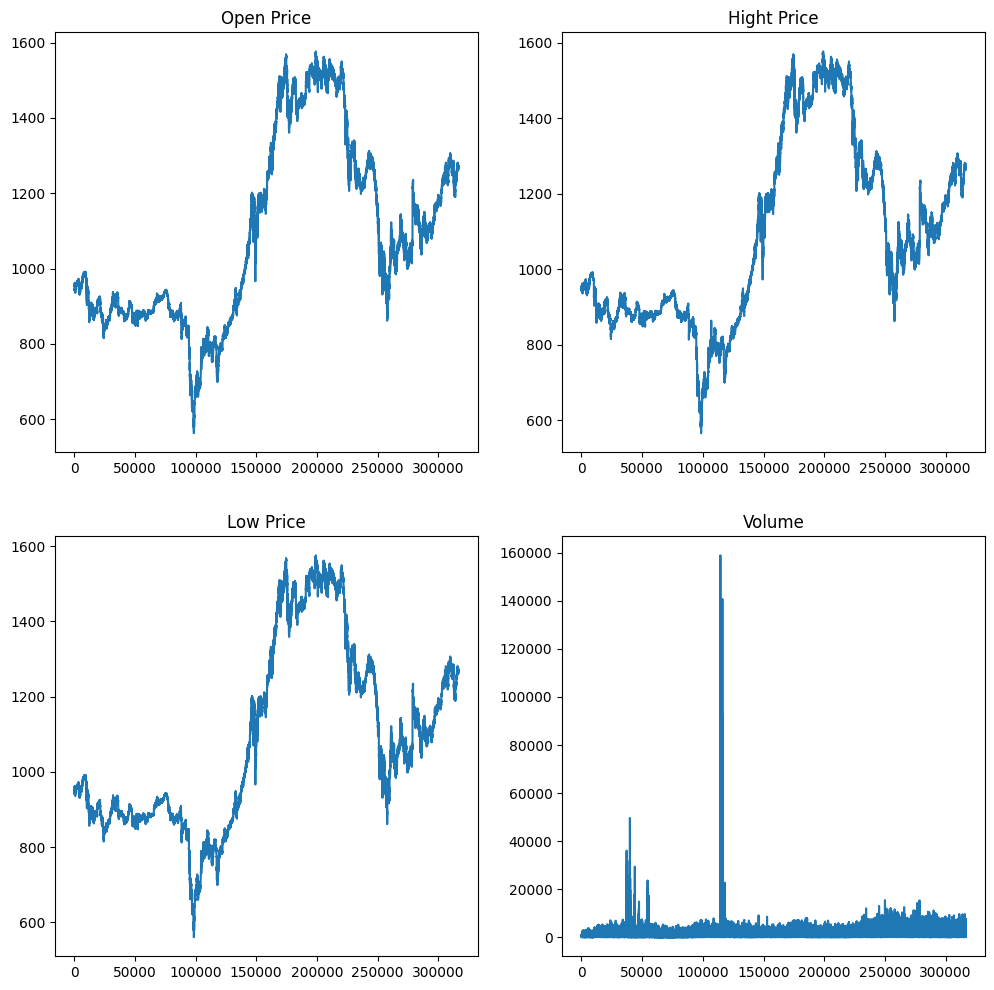

In [165]:
fig, ax = plt.subplots(ncols=2, nrows=2, figsize=(12,12))
X_train['Open'].plot(ax=ax[0,0])
ax[0,0].set_title("Open Price")
X_train['High'].plot(ax=ax[0,1])
ax[0,1].set_title("Hight Price")
X_train['Low'].plot(ax=ax[1,0])
ax[1,0].set_title("Low Price")
X_train['Volume'].plot(ax=ax[1,1])
ax[1,1].set_title("Volume")


Text(0.5, 1.0, 'Close Price')

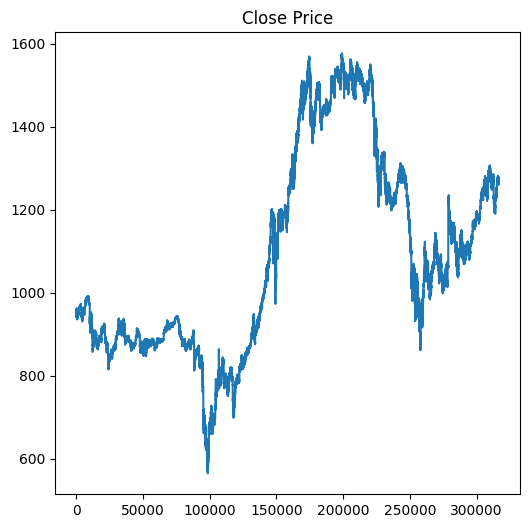

In [166]:
plt.figure(figsize=(6,6))
X_train['Close'].plot()
plt.title("Close Price")

## Remove Outliers

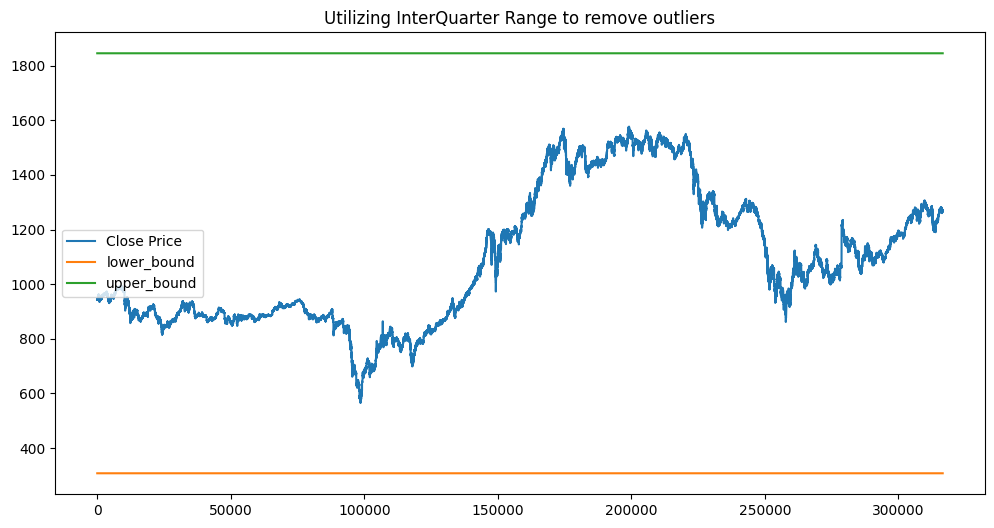

In [167]:
# Sử dụng kỹ thuật InterQuarter Range để phát hiện outliers
sorted_close_values = sorted(X_train['Close'].values)
num_close_values = len(sorted_close_values)
if num_close_values%2:
    median = sorted_close_values[num_close_values//2]
    lower_half = sorted_close_values[:num_close_values//2]
    upper_half = sorted_close_values[num_close_values//2+1:]
    q1 = (lower_half[len(lower_half)//2]+lower_half[len(lower_half)//2+1])/2
    q3 = (lower_half[len(upper_half)//2]+upper_half[len(upper_half)//2+1])/2
else:
    median = (sorted_close_values[num_close_values//2]+sorted_close_values[num_close_values//2+1])/2
    lower_half = sorted_close_values[:num_close_values//2+1]
    upper_half = sorted_close_values[num_close_values//2+1:]
    q1 = lower_half[len(lower_half)//2]
    q3 = upper_half[len(upper_half)//2]
iqr = q3-q1
lower_bound = q1-1.5*iqr
upper_bound = q3+1.5*iqr
plt.figure(figsize=(12,6))
plt.plot(X_train['Close'].values, label="Close Price")
plt.plot([lower_bound]*len(X_train), label="lower_bound")
plt.plot([upper_bound]*len(X_train), label="upper_bound")
plt.title("Utilizing InterQuarter Range to remove outliers")
plt.legend()

Text(0.5, 1.0, 'Residual')

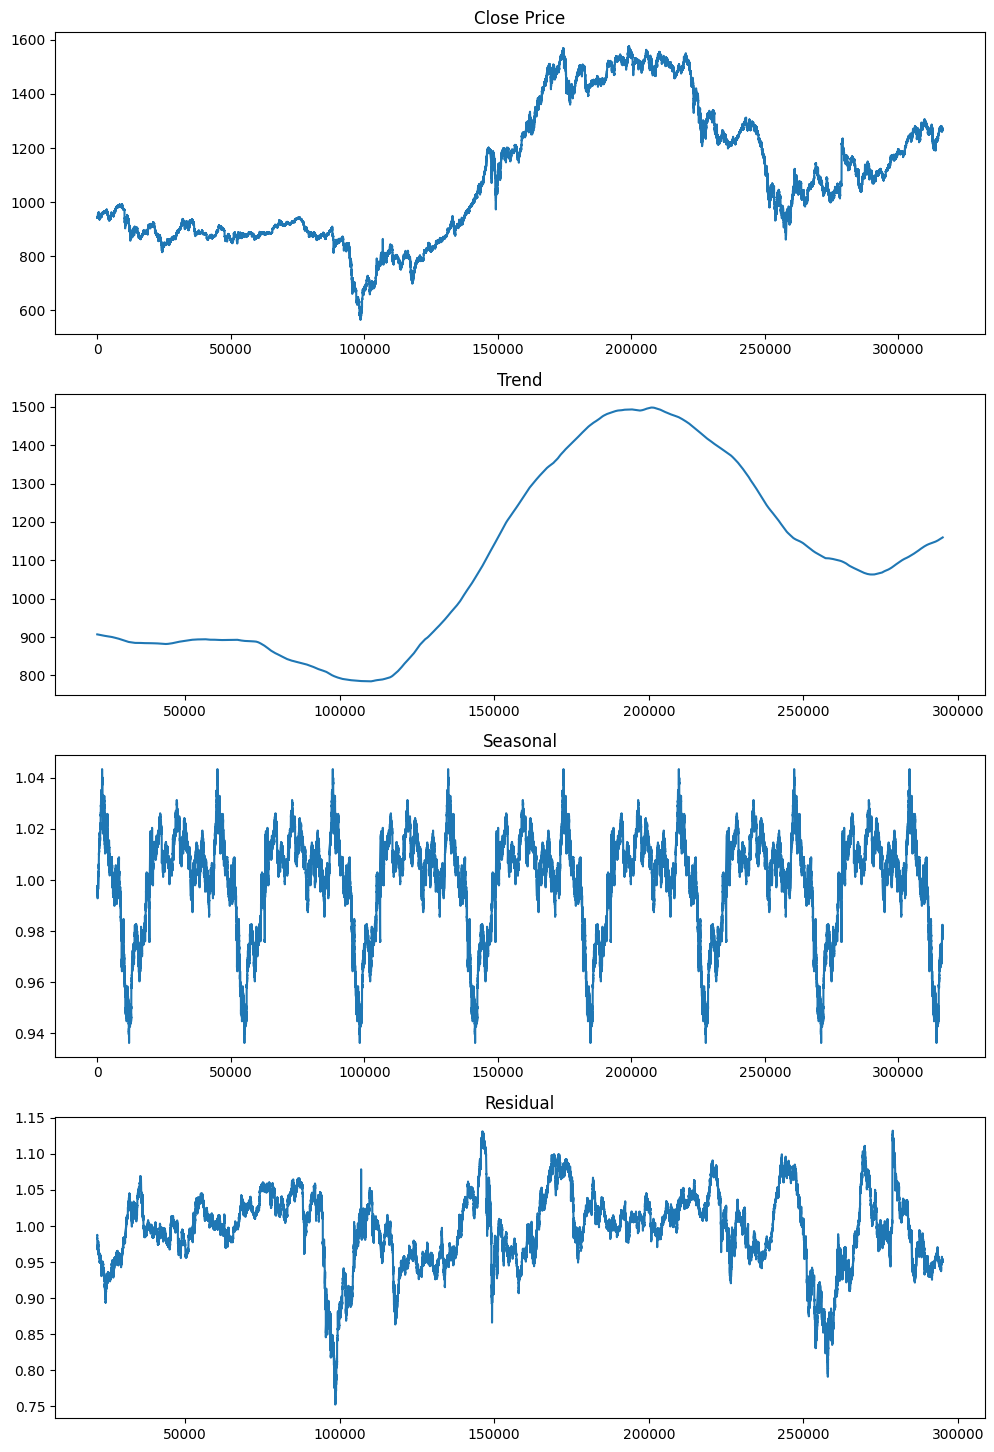

In [168]:
decomposition = seasonal_decompose(X_train['Close'], model='multiplicate', period=60*24*30)
fig, ax = plt.subplots(nrows=4, ncols=1, figsize=(12,18))
X_train['Close'].plot(ax=ax[0])
ax[0].set_title("Close Price")
decomposition.trend.plot(ax=ax[1])
ax[1].set_title("Trend")
decomposition.seasonal.plot(ax=ax[2])
ax[2].set_title("Seasonal")
decomposition.resid.plot(ax=ax[3])
ax[3].set_title("Residual")

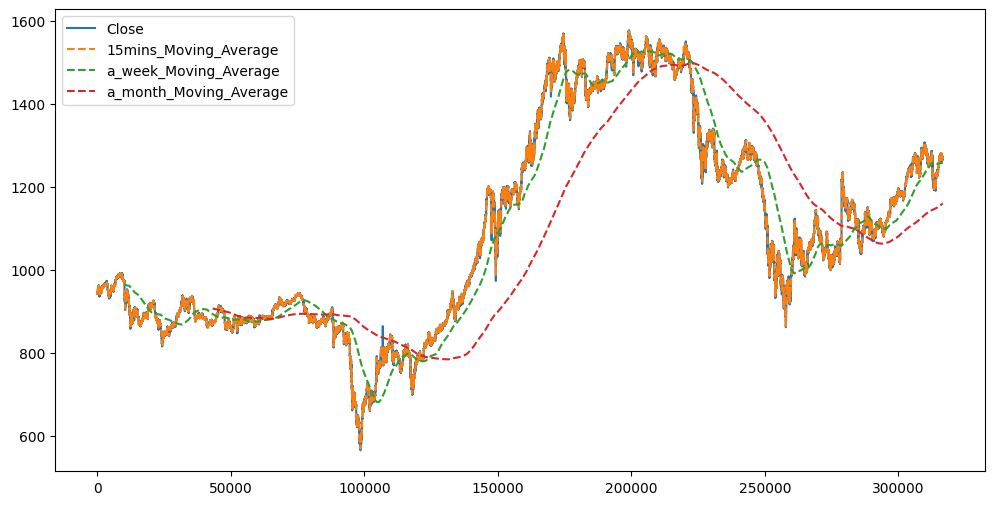

In [169]:
X_train["15mins_Moving_Average"] = X_train['Close'].rolling(window=15).mean()
X_train["a_week_Moving_Average"] = X_train['Close'].rolling(window=60*24*7).mean()
X_train["a_month_Moving_Average"] = X_train['Close'].rolling(window=60*24*30).mean()
plt.figure(figsize=(12,6))
plt.plot(X_train['Close'], label="Close")
plt.plot(X_train["15mins_Moving_Average"], label="15mins_Moving_Average", linestyle="--")
plt.plot(X_train["a_week_Moving_Average"], label="a_week_Moving_Average", linestyle="--")
plt.plot(X_train["a_month_Moving_Average"], label="a_month_Moving_Average", linestyle="--")
plt.legend(loc="upper left")

# Tiếp cận theo hướng Classification

In [178]:
def crate_label(pct):
    return int(pct) if pct<10 else 10
df['Labels'] = df['Pct_Change'].map(crate_label)
X_train = df[features].iloc[:-test_size]
X_test = df[features].iloc[-test_size:]
y_train = df['Labels'].iloc[:-test_size]
y_test = df['Labels'].iloc[-test_size:]

# Huấn luyện mô hình Random Forest
model = RandomForestClassifier(n_estimators=100, random_state=11)
model.fit(X_train, y_train)

# Đánh giá mô hình
y_pred = model.predict(X_test)
print(classification_report(y_test, y_pred))

              precision    recall  f1-score   support

          -3       0.00      0.00      0.00         0
          -1       0.00      0.00      0.00        85
           0       1.00      1.00      1.00     43052
           1       0.01      0.02      0.01        63

    accuracy                           0.99     43200
   macro avg       0.25      0.25      0.25     43200
weighted avg       0.99      0.99      0.99     43200



c:\Users\huymo\miniconda3\Lib\site-packages\sklearn\metrics\_classification.py:1531: UndefinedMetricWarning: Recall is ill-defined and being set to 0.0 in labels with no true samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
c:\Users\huymo\miniconda3\Lib\site-packages\sklearn\metrics\_classification.py:1531: UndefinedMetricWarning: Recall is ill-defined and being set to 0.0 in labels with no true samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
c:\Users\huymo\miniconda3\Lib\site-packages\sklearn\metrics\_classification.py:1531: UndefinedMetricWarning: Recall is ill-defined and being set to 0.0 in labels with no true samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))


Text(45.722222222222214, 0.5, 'True Label')

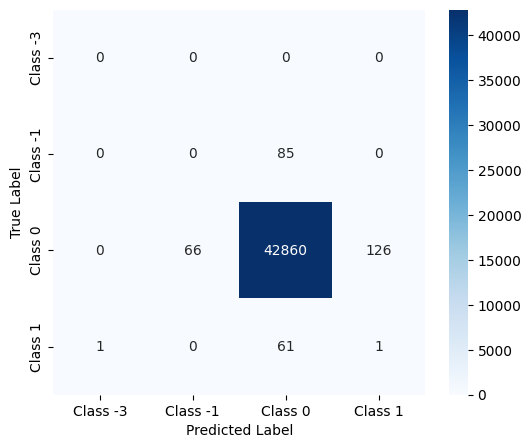

In [179]:
cm = confusion_matrix(y_test, y_pred)
labels = ['Class -3','Class -1', 'Class 0', 'Class 1']
plt.figure(figsize=(6, 5))
sns.heatmap(cm, annot=True, fmt='d', cmap='Blues', xticklabels=labels, yticklabels=labels)
plt.xlabel('Predicted Label')
plt.ylabel('True Label')

Mô hình có khả năng dự đoán khá chính xác đối với class 0 (precision đạt 0.99). Tuy nhiên lại cực kỳ tệ đối với class -1 và 1. Điều này là do số lượng các samples có label là 0 được sử dụng để huấn luyện mô hình chiếm một phần áp đảo, trong khi các labels còn lại chỉ chiếm một phần cực kỳ nhỏ.

In [172]:
# Áp dụng kỹ thuật Class Weight nhằm giúp mô hình tập trung vào các class thiểu số
from sklearn.utils.class_weight import compute_class_weight
class_weights = compute_class_weight('balanced', classes=np.unique(y_train), y=y_train)
class_weight_dict = {label: weight for label, weight in zip(np.unique(y_train), class_weights)}
# Thử huấn luyện lại mô hình sau khi đã áp dụng kỹ thuật Class Weight
model = RandomForestClassifier(class_weight=class_weight_dict)
model.fit(X_train, y_train)
y_pred = model.predict(X_test)
print(classification_report(y_test, y_pred))

              precision    recall  f1-score   support

          -3       0.00      0.00      0.00         0
          -1       0.00      0.00      0.00        85
           0       1.00      1.00      1.00     43052
           1       0.03      0.02      0.02        63

    accuracy                           0.99     43200
   macro avg       0.26      0.25      0.25     43200
weighted avg       0.99      0.99      0.99     43200



c:\Users\huymo\miniconda3\Lib\site-packages\sklearn\metrics\_classification.py:1531: UndefinedMetricWarning: Recall is ill-defined and being set to 0.0 in labels with no true samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
c:\Users\huymo\miniconda3\Lib\site-packages\sklearn\metrics\_classification.py:1531: UndefinedMetricWarning: Recall is ill-defined and being set to 0.0 in labels with no true samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
c:\Users\huymo\miniconda3\Lib\site-packages\sklearn\metrics\_classification.py:1531: UndefinedMetricWarning: Recall is ill-defined and being set to 0.0 in labels with no true samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))


Các kỹ thuật cân bằn class tỏ ra không hiệu quả trong tập dữ liệu này, do số lượng nhãn 0 chiếm đến khoảng 98%. Một cách cụ thể, việc áp dụng Upsampling sẽ làm cho dữ liệu thiểu số bị lặp lại quá nhiều, trong khi việc áp dụng Downsampling lại làm mất mác phần lớn dữ liệu quan trọng của class 0 và phá vỡ tính tiên lục của TIme Series. Do đó, chúng ta chuyển sang cách tiếp cận tiếp theo là theo hướng hồi quy.

# Tiếp cận theo hướng hồi quy (Regression)

In [ ]:
import numpy as np
import matplotlib.pyplot as plt
from sklearn.model_selection import train_test_split
from sklearn.ensemble import RandomForestRegressor
from sklearn.metrics import mean_absolute_error, mean_squared_error, r2_score

X_train = df[features][:-test_size]
y_train = df['Close_15mins_after'][:-test_size]
X_test = df[features][-test_size:]
y_test = df['Close_15mins_after'][-test_size:]

model = RandomForestRegressor(n_estimators=100, random_state=42)

model.fit(X_train, y_train)

y_pred = model.predict(X_test)

mse = mean_squared_error(y_test, y_pred)
mae = mean_absolute_error(y_test, y_pred)
r2 = r2_score(y_test, y_pred)

print(f"Mean Squared Error (MSE): {mse:.4f}")
print(f"Mean Absolute Error (MAE): {mae:.4f}")
print(f"R² Score: {r2:.4f}")


Mean Squared Error (MSE): 10.9411
Mean Absolute Error (MSE): 2.3247
R² Score: 0.9857


In [175]:
pct_pred = (y_pred-X_test['Close'])/X_test['Close']
pct_true = df['Labels'].iloc[-test_size:]
mapped_pct_pred = pct_pred.map(crate_label)
print(classification_report(mapped_pct_pred, pct_true))

              precision    recall  f1-score   support

          -1       0.00      0.00      0.00         0
           0       1.00      1.00      1.00     43200
           1       0.00      0.00      0.00         0

    accuracy                           1.00     43200
   macro avg       0.33      0.33      0.33     43200
weighted avg       1.00      1.00      1.00     43200



c:\Users\huymo\miniconda3\Lib\site-packages\sklearn\metrics\_classification.py:1531: UndefinedMetricWarning: Recall is ill-defined and being set to 0.0 in labels with no true samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
c:\Users\huymo\miniconda3\Lib\site-packages\sklearn\metrics\_classification.py:1531: UndefinedMetricWarning: Recall is ill-defined and being set to 0.0 in labels with no true samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
c:\Users\huymo\miniconda3\Lib\site-packages\sklearn\metrics\_classification.py:1531: UndefinedMetricWarning: Recall is ill-defined and being set to 0.0 in labels with no true samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))


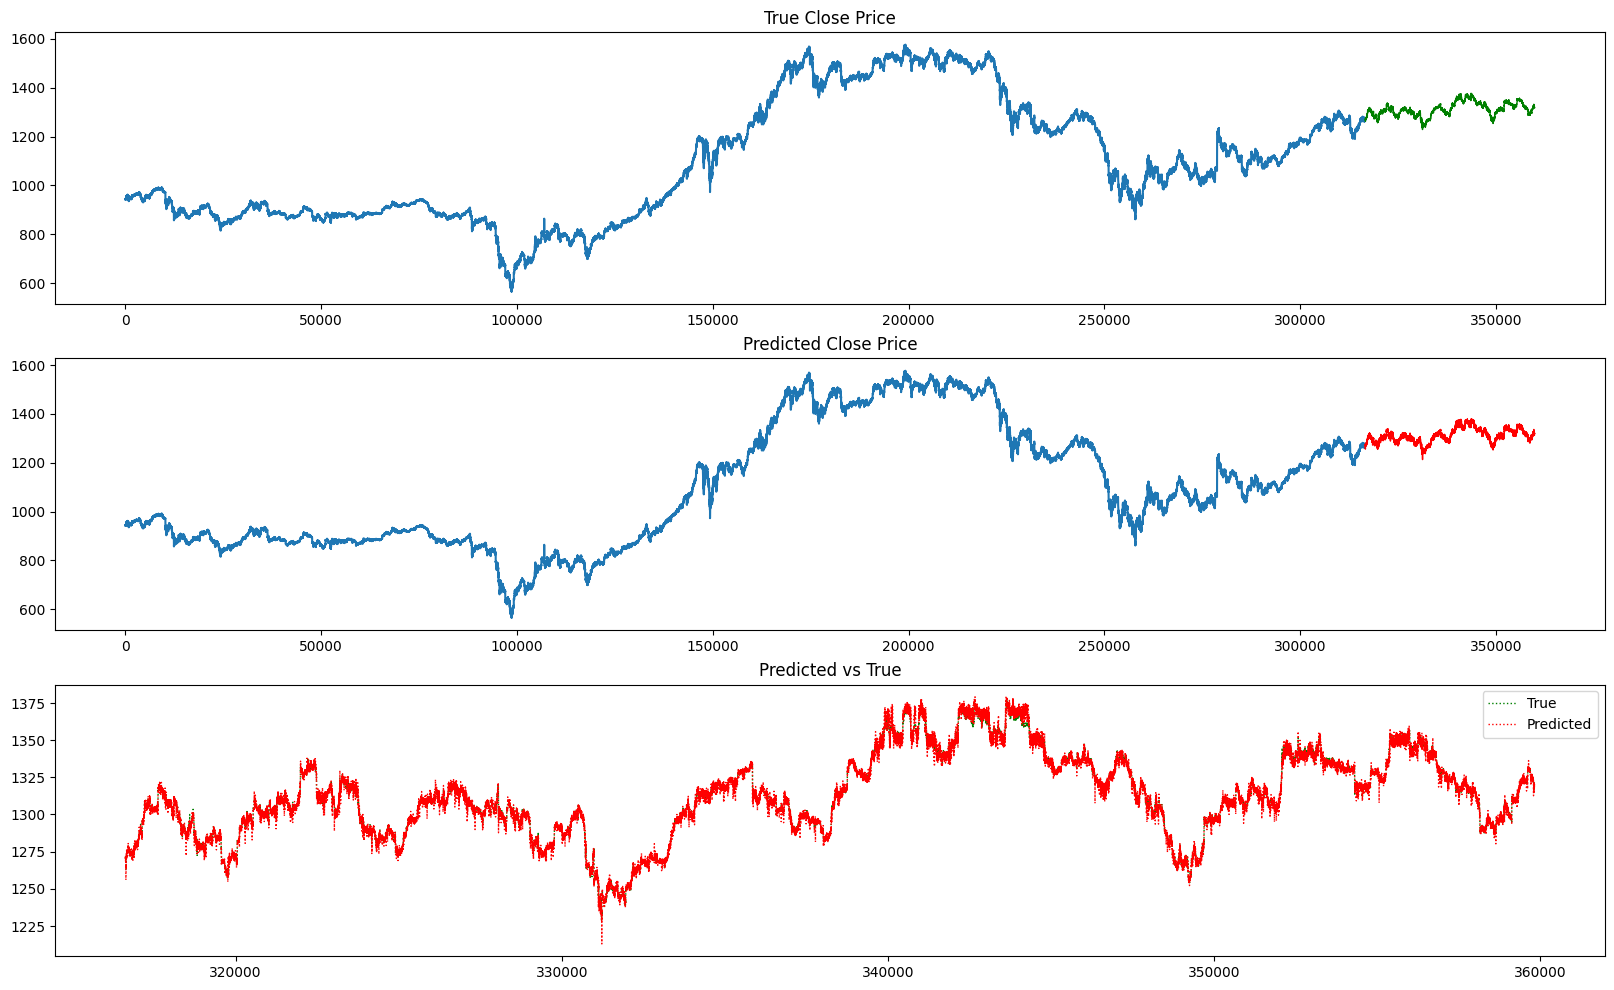

In [ ]:
fig, ax = plt.subplots(nrows=3, ncols=1, figsize=(20,12))
ax[0].plot(np.arange(0,len(X_train)), np.array(X_train['Close']), label="Train")
ax[0].plot(np.arange(len(X_train),len(X_train)+len(X_test)), np.array(X_test['Close']), linewidth=1, color='green', label="Test")
ax[0].set_title("True Close Price")
ax[1].plot(np.arange(0,len(X_train)), np.array(X_train['Close']), label="Train")
ax[1].plot(np.arange(len(X_train),len(X_train)+len(X_test)), np.array(y_pred), linewidth=1, color='red', label="Predicted")
ax[1].set_title("Predicted Close Price")
ax[2].plot(np.arange(len(X_train),len(X_train)+len(X_test)), np.array(X_test['Close']), linewidth=1, color='green', label="True", linestyle = 'dotted')
ax[2].plot(np.arange(len(X_train),len(X_train)+len(X_test)), np.array(y_pred), linewidth=1, color='red', label="Predicted", linestyle = 'dotted')
ax[2].set_title("Predicted vs True")
plt.legend()

red line (Predicted Close Price) gần như tương đồng so với green line (True Close Price) điều này cho thấy mô hình có khả năng dự đoán khá chính xác.